In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py
from collections import defaultdict

from astropy.cosmology import Planck18
cosmo = Planck18

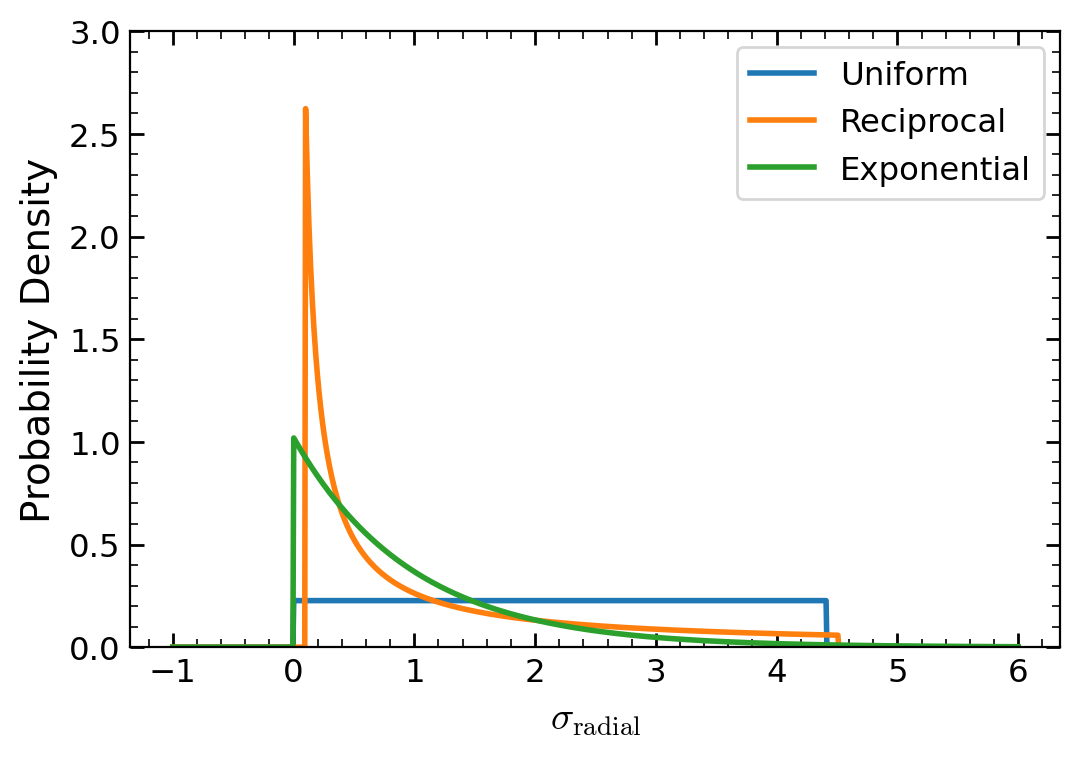

In [ ]:
from scipy.stats import uniform
from scipy.stats import expon

a, b = 1e-1, 1000/128/np.sqrt(3)

f, ax = plt.subplots(1, 1, figsize=(6, 4))
x_ = np.linspace(-1, 6, 1000)

pdf = uniform.pdf(x_, loc=0, scale=b-a)
ax.plot(x_, pdf, label='Uniform')

# log_samples = np.exp(np.random.uniform(np.log(a), np.log(b), size=10000))
# ax.hist(log_samples, bins=50, density=True, alpha=0.5, label='Log-uniform')

reciprocal_pdf = np.where((x_ > a) & (x_ < b), 1 /
                          (x_ * (np.log(b) - np.log(a))), 0)
ax.plot(x_, reciprocal_pdf, label='Reciprocal')

scale = b / expon.ppf(0.99, scale=1.)
expon_pdf = expon.pdf(x_, scale=scale)
ax.plot(x_, expon_pdf, label='Exponential')

ax.set_ylim(0, 3)
ax.set_xlabel(r'$\sigma_{\rm radial}$')
ax.set_ylabel('Probability Density')
ax.legend()
# ax.semilogy()

In [6]:
b, scale

(4.510548978043952, 0.97945326575942)

In [25]:
from cmass.infer.preprocess import _load_single_simulation_summaries

suitepath = '/ocean/projects/phy240015p/mho1/cmass-ili/quijotelike/fastpm_recnoise/L1000-N128'
simpaths = os.listdir(suitepath)

params = []
for d in tqdm(simpaths):
    simpath = join(suitepath, d)
    _, y = _load_single_simulation_summaries(
        simpath, 'simbig_lightcone', include_hod=False, include_noise=True)
    params.append(np.array(y))

100%|██████████| 2000/2000 [06:50<00:00,  4.87it/s]


In [26]:
params = np.concatenate(params)

[]

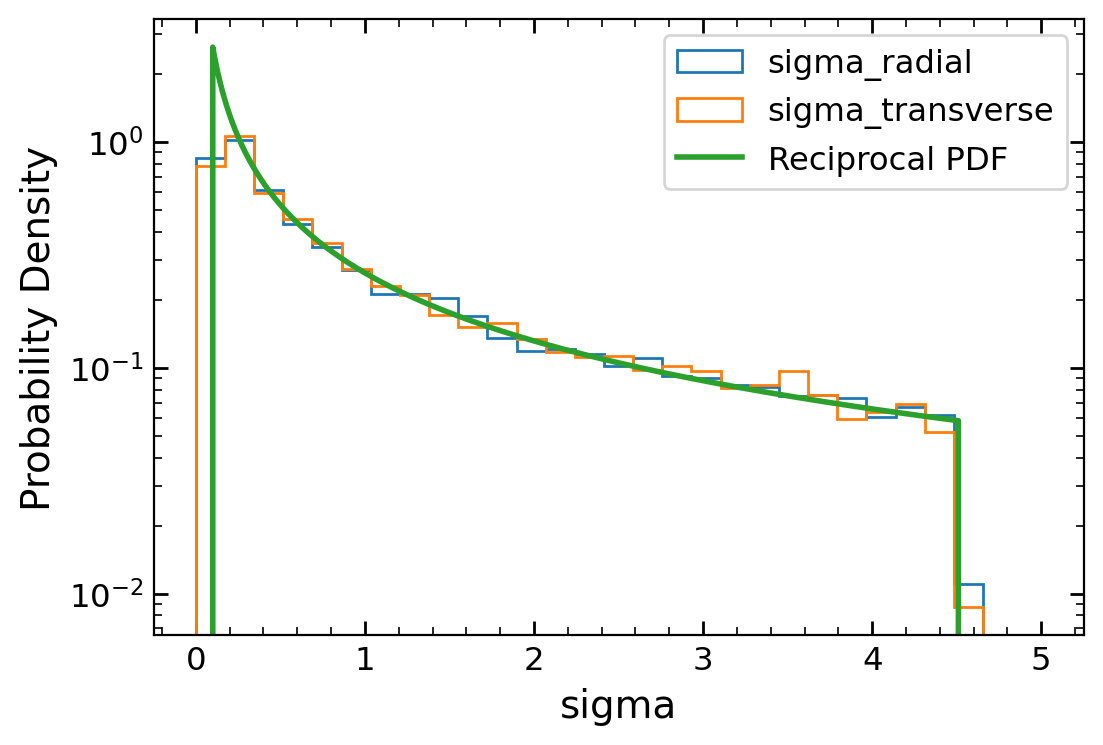

In [28]:
be = np.linspace(0, 5, 30)

f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(params[:, -2], bins=be, density=True,
        histtype='step', label='sigma_radial')
ax.hist(params[:, -1], bins=be, density=True,
        histtype='step', label='sigma_transverse')

a, b = 1e-1, 1000/128/np.sqrt(3)
reciprocal_pdf = np.where((x_ > a) & (x_ < b), 1 /
                          (x_ * (np.log(b) - np.log(a))), 0)
ax.plot(x_, reciprocal_pdf, label='Reciprocal PDF')
ax.legend()
ax.set_xlabel('sigma')
ax.set_ylabel('Probability Density')
ax.semilogy()

### New noising scheme in `lightcone.cpp`

In [102]:
filename = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained/L3000-N384/663/sgc_lightcone/hod00001_aug00001.h5'
with h5py.File(filename, 'r') as f:
    rdz = f['ra'][:], f['dec'][:], f['z'][:]
    for k, v in f.attrs.items():
        if 'noise' in k:
            print(f'{k}: {v}')

rdz = np.array(rdz).T
mask = (rdz[:, 0] > -5) & (rdz[:, 0] < 5)
mask &= (rdz[:, 2] > 0.49) & (rdz[:, 2] < 0.51)
rdz = rdz[mask]

diagname = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained/L3000-N384/663/diag/sgc_lightcone/hod00001_aug00001.h5'
if os.path.isfile(diagname):
    summ = {}
    with h5py.File(diagname, 'r') as f:
        for k, v in f.attrs.items():
            if 'noise' in k:
                print(f'{k}: {v}')
        for k, v in f.items():
            summ[k] = v[:]

noise_radial: 1.1744870021196305
noise_transverse: 0.1587498623954794
noise_dist: Reciprocal
noise_radial: 1.1744870021196305
noise_transverse: 0.1587498623954794


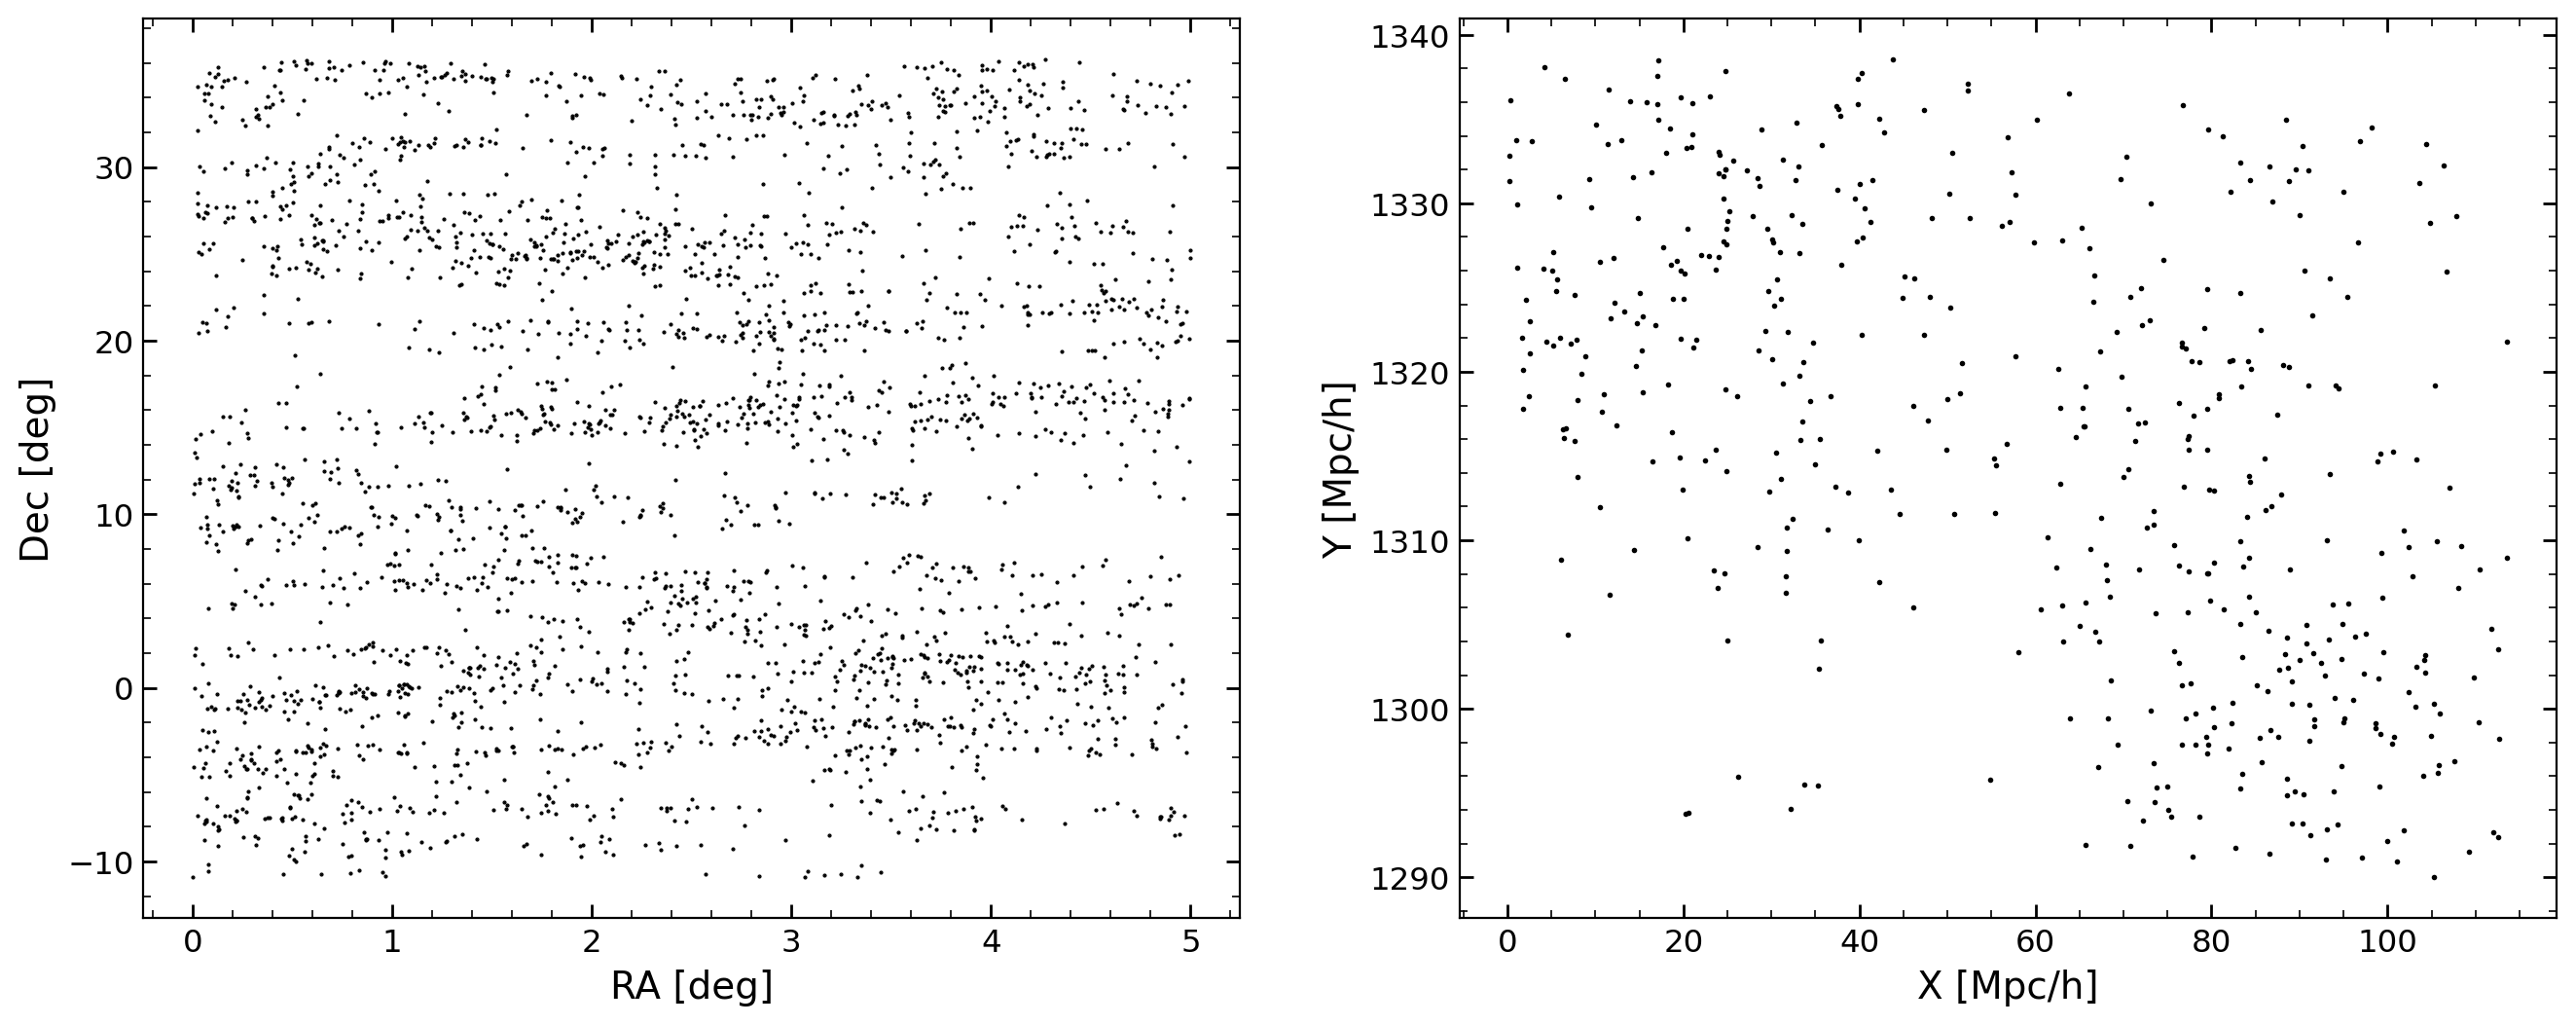

In [103]:
from cmass.survey.tools import sky_to_xyz
from astropy.cosmology import Planck18 as cosmo


def plot_zslice(ax, rdz, z0=0.5, dz=0.01):
    ra, dec, z = rdz.T
    mask = np.abs(z-z0) < dz
    ax.plot((ra[mask]+180) % 360 - 180, dec[mask], 'k.', markersize=1)
    ax.set_xlabel('RA [deg]')
    ax.set_ylabel('Dec [deg]')


def plot_decslice(ax, rdz, dec0=0, ddec=3):
    ra, dec, z = rdz.T
    xyz = sky_to_xyz(rdz, cosmo=cosmo)

    mask = np.abs(dec-dec0) < ddec
    xyz = xyz[mask]
    ax.plot(xyz[:, 1], xyz[:, 0], 'k.', markersize=2)
    ax.set_xlabel('X [Mpc/h]')
    ax.set_ylabel('Y [Mpc/h]')


f, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
plot_zslice(ax, rdz)

ax = axs[1]
plot_decslice(ax, rdz)

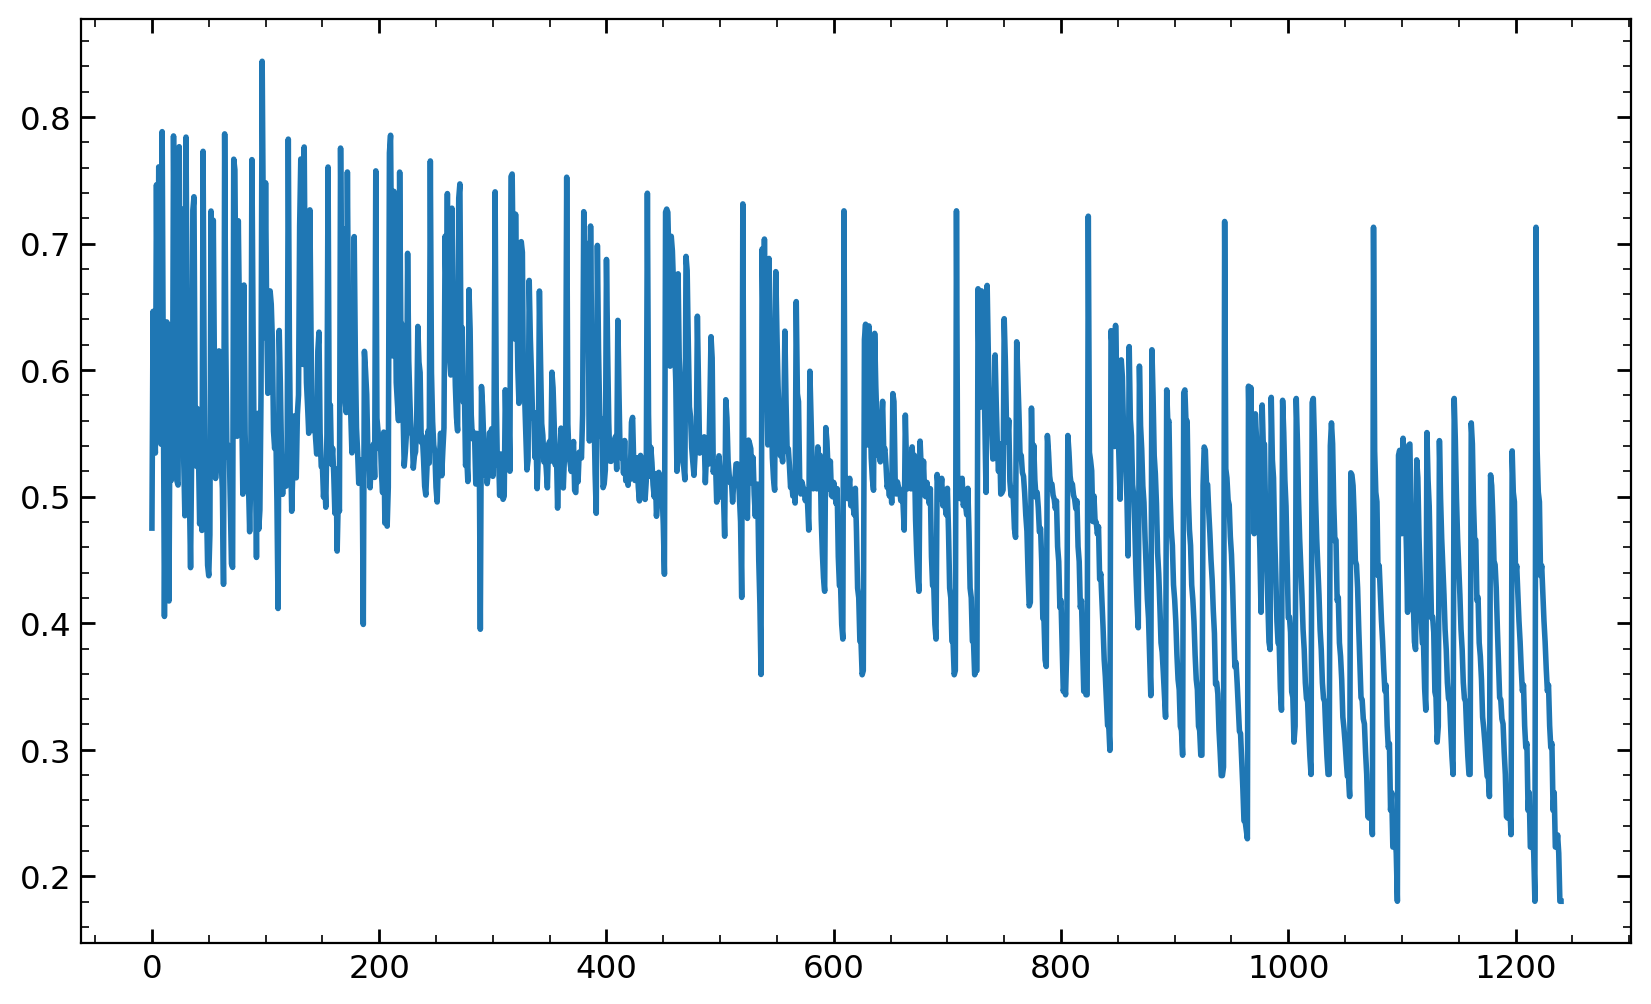

In [104]:
plt.plot(summ['Qk'][0])

### Check outputs

In [ ]:
# check what is run

from collections import defaultdict
suitedir = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained/L3000-N384'

record = {}

lhidlist = os.listdir(suitedir)
tracers = [f'{cap}_lightcone' for cap in ['simbig', 'sgc', 'mtng', 'ngc']]
for t in tracers:
    record[t] = defaultdict(lambda: 0)

for lhid in tqdm(lhidlist):
    simdir = join(suitedir, lhid)
    if not os.path.isdir(simdir):
        continue
    for tracer in tracers:
        diagdir = join(simdir, 'diag', tracer)
        if not os.path.isdir(diagdir):
            continue
        diaglist = os.listdir(diagdir)
        for d in diaglist:
            diagfile = join(diagdir, d)
            with h5py.File(diagfile, 'r') as f:
                for k in f.keys():
                    record[tracer][k] += 1

for k, d in record.items():
    print('\n', k)
    for key, value in d.items():
        print(f"\t{key}:\t{value}")

100%|██████████| 3000/3000 [00:13<00:00, 217.44it/s]


 simbig_lightcone
	Bk:	2943
	Bk_k123:	2943
	Pk:	2958
	Pk_k3D:	2958
	Qk:	2943
	bPk:	2943
	bPk_k3D:	2943
	nz:	2958
	nz_bins:	2958

 sgc_lightcone
	Bk:	2943
	Bk_k123:	2943
	Pk:	2958
	Pk_k3D:	2958
	Qk:	2943
	bPk:	2943
	bPk_k3D:	2943
	nz:	2958
	nz_bins:	2958

 mtng_lightcone
	Bk:	2944
	Bk_k123:	2944
	Pk:	2959
	Pk_k3D:	2959
	Qk:	2944
	bPk:	2944
	bPk_k3D:	2944
	nz:	2959
	nz_bins:	2959

 ngc_lightcone
	Pk:	2957
	Pk_k3D:	2957
	nz:	2957
	nz_bins:	2957


In [11]:
# check n(z)'s

from collections import defaultdict
suitedir = '/ocean/projects/phy240015p/mho1/cmass-ili/mtnglike/fastpm_constrained/L3000-N384'

record = {}

lhidlist = os.listdir(suitedir)
tracers = [f'{cap}_lightcone' for cap in ['simbig', 'sgc', 'mtng', 'ngc']]
for t in tracers:
    record[t] = defaultdict(lambda: [])

for lhid in tqdm(lhidlist):
    simdir = join(suitedir, lhid)
    if not os.path.isdir(simdir):
        continue
    for tracer in tracers:
        diagdir = join(simdir, 'diag', tracer)
        if not os.path.isdir(diagdir):
            continue
        diaglist = os.listdir(diagdir)
        for d in diaglist:
            diagfile = join(diagdir, d)
            with h5py.File(diagfile, 'r') as f:
                if 'nz' in f:
                    record[tracer]['nz'].append(f['nz'][:])
                    record[tracer]['cosmo'].append(f.attrs['cosmo_params'])
                    record[tracer]['hod'].append(f.attrs['HOD_params'])

100%|██████████| 3000/3000 [02:56<00:00, 16.99it/s]


In [14]:
for k, d in record.items():
    print('\n', k)
    for key, value in d.items():
        print(f"\t{key}:\t{len(value)}")


 simbig_lightcone
	nz:	2958
	cosmo:	2958
	hod:	2958

 sgc_lightcone
	nz:	2958
	cosmo:	2958
	hod:	2958

 mtng_lightcone
	nz:	2959
	cosmo:	2959
	hod:	2959

 ngc_lightcone
	nz:	2957
	cosmo:	2957
	hod:	2957


In [26]:

from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from cmass.diagnostics.geometry import SURVEY_GEOMETRIES


def get_nofz(zhist, zedges, fsky, cosmo):

    # Calculate comoving volume of each spherical shell corresponding to a bin
    R_hi = cosmo.comoving_distance(zedges[1:]).to_value(u.Mpc) * cosmo.h
    R_lo = cosmo.comoving_distance(zedges[:-1]).to_value(u.Mpc) * cosmo.h
    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    # Avoid division by zero for empty bins
    dV[dV == 0] = np.inf

    # Create a spline interpolator for n(z)
    nofz = InterpolatedUnivariateSpline(
        0.5*(zedges[1:] + zedges[:-1]), zhist/dV, ext='const')
    return nofz

In [29]:

zedges = np.linspace(0.4, 0.7, 101)
zcens = 0.5 * (zedges[1:] + zedges[:-1])
for t in tracers:
    print(t)
    fsky = SURVEY_GEOMETRIES[t.split('_')[0]]['fsky']
    nofzs = []

    for k in tqdm(record[t]['nz']):
        nofz = get_nofz(k, zedges, fsky, cosmo)
        _y = nofz(zcens)
        nofzs.append(_y)

    record[t]['nofz'] = np.array(nofzs)

simbig_lightcone


100%|██████████| 2958/2958 [00:07<00:00, 400.79it/s]


sgc_lightcone


100%|██████████| 2958/2958 [00:07<00:00, 406.02it/s]


mtng_lightcone


100%|██████████| 2959/2959 [00:07<00:00, 396.28it/s]


ngc_lightcone


100%|██████████| 2957/2957 [00:07<00:00, 403.32it/s]


In [ ]:
trues = {}

datafiles = {
    'simbig_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_simbig/L2000-N256/0/simbig_lightcone/hod00000_aug00000.h5',
    'sgc_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_sgc/L2000-N256/0/sgc_lightcone/hod00000_aug00000.h5',
    'mtng_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/mtng/nbody/L3000-N384/0/mtng_lightcone/hod00000_aug00000.h5',
    'ngc_lightcone': '/ocean/projects/phy240015p/mho1/cmass-ili/real_data/cmass_ngc/L3000-N384/0/ngc_lightcone/hod00000_aug00000.h5',
}


for t, filename in datafiles.items():
    with h5py.File(filename, 'r') as f:
        redshifts = f['z'][:]
    fsky = SURVEY_GEOMETRIES[t.split('_')[0]]['fsky']
    nz = np.histogram(redshifts, bins=zedges)[0]
    nofz = get_nofz(nz, zedges, fsky, cosmo)(zcens)
    trues[t] = {
        'nz': nz,
        'nofz': nofz
    }

Text(0.5, 0, '$z$')

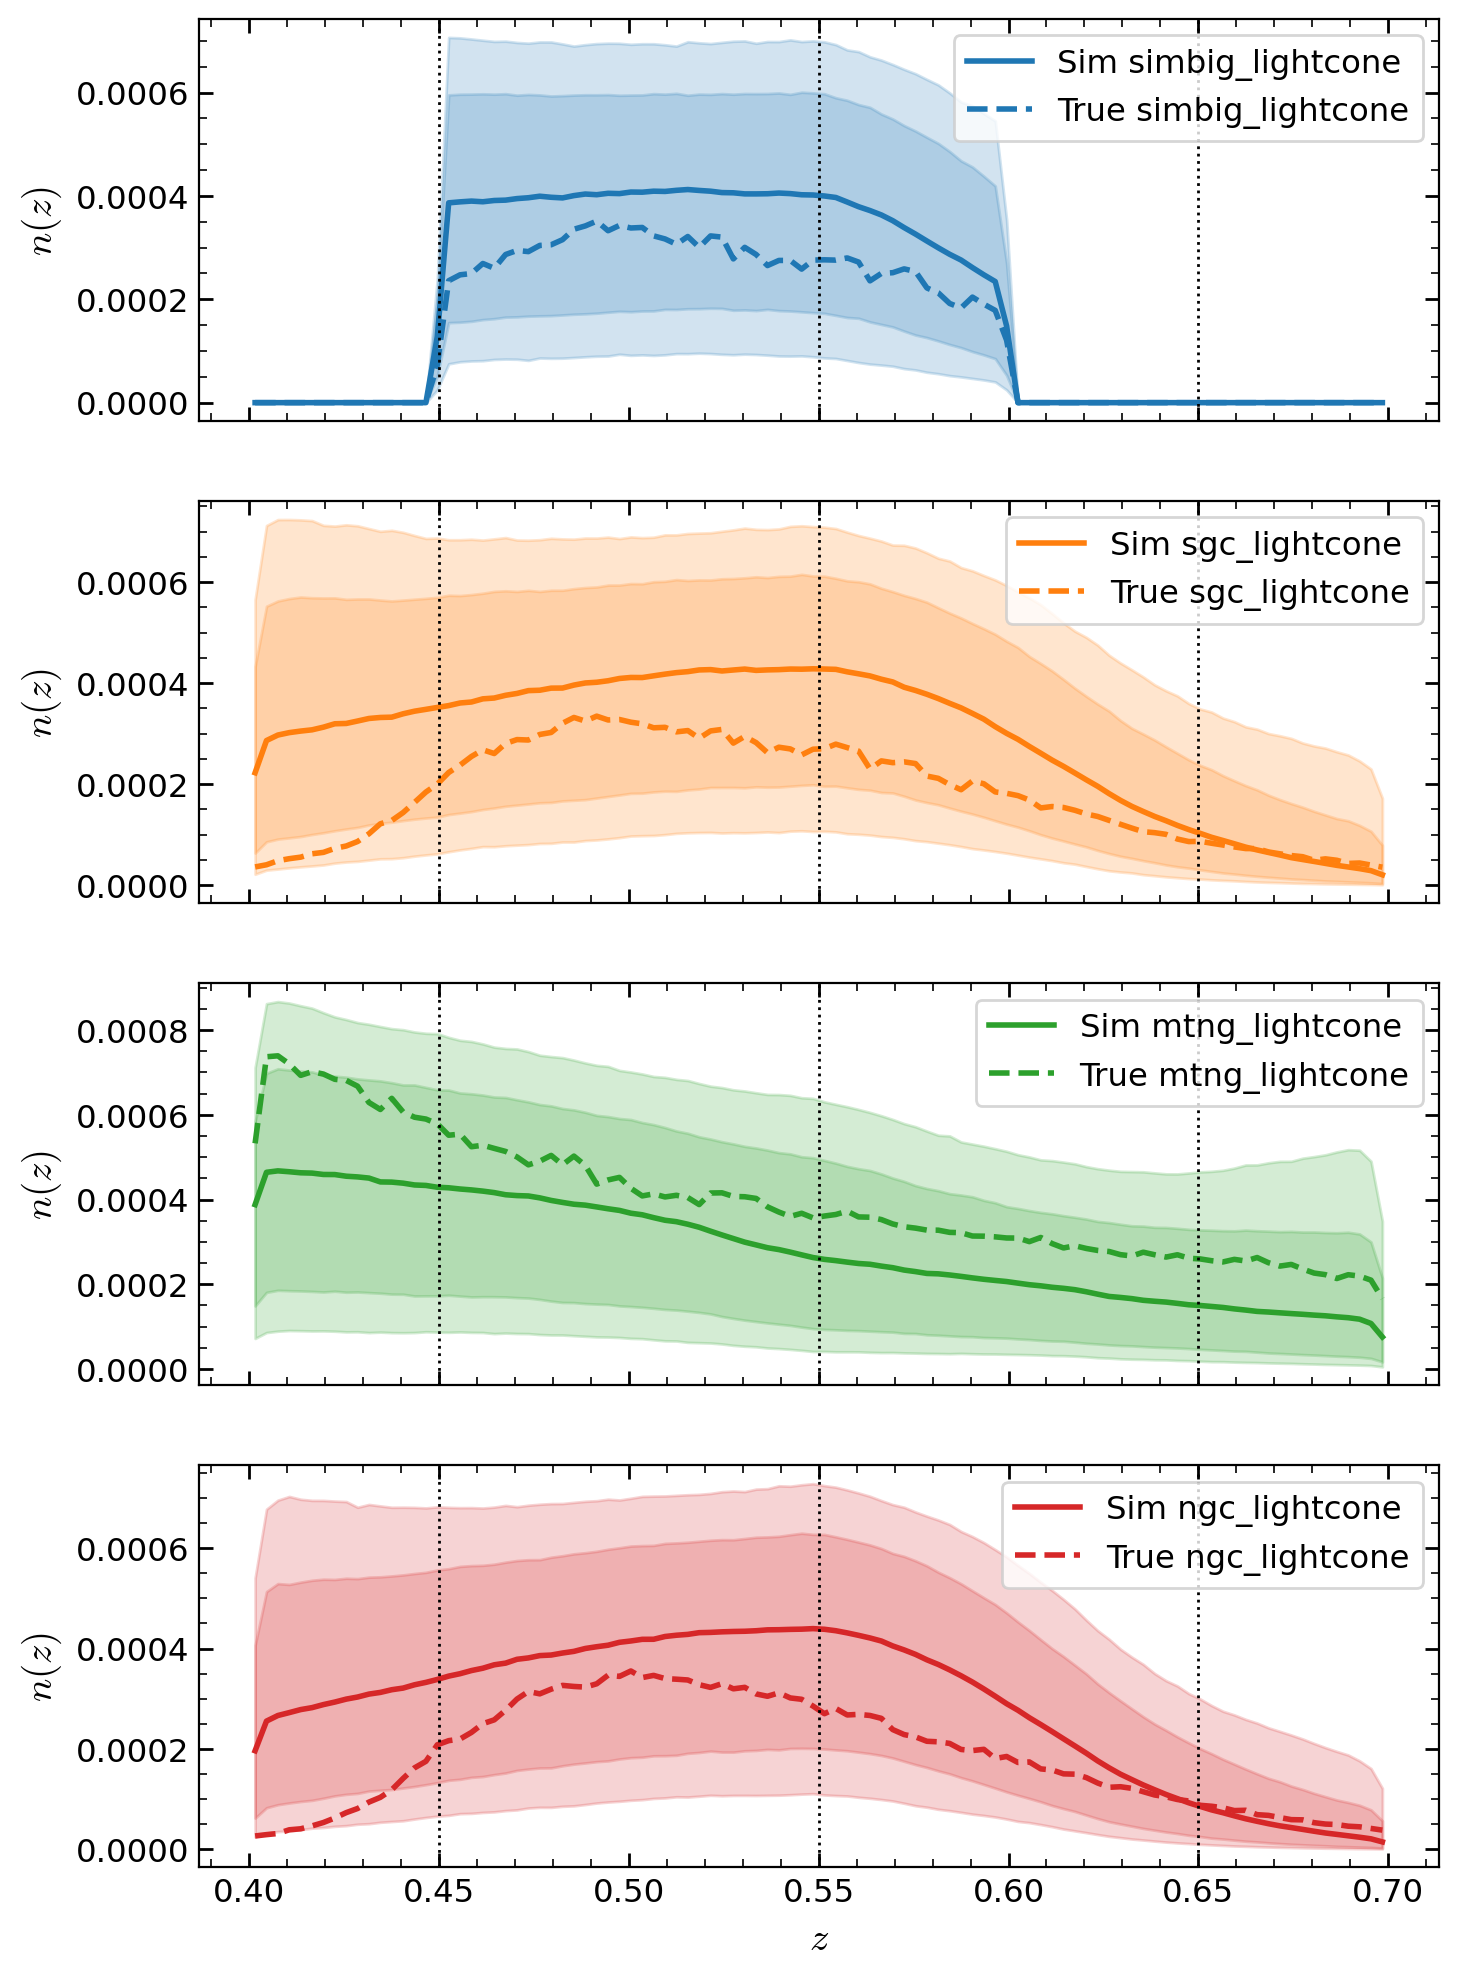

In [50]:
f, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
for i, t in enumerate(tracers):
    ax = axs[i]
    _x = zcens
    _y = record[t]['nofz']
    percs = np.percentile(_y, [50, 16, 84, 5, 95], axis=0)
    ax.fill_between(_x, percs[1], percs[2], alpha=0.2, color=f'C{i}')
    ax.fill_between(_x, percs[3], percs[4], alpha=0.2, color=f'C{i}')
    ax.plot(_x, percs[0], label=f'Sim {t}', color=f'C{i}')

    ax.plot(_x, trues[t]['nofz'], '--', color=f'C{i}', label=f'True {t}')
    ax.set(ylabel='$n(z)$')
    ax.legend()

    for zbin in [0.45, 0.55, 0.65]:
        ax.axvline(zbin, color='k', linestyle=':', alpha=1, lw=1)
ax.set_xlabel('$z$')